In [1]:
# import the libraries
import numpy as np
import pickle
import random
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Specify the path to the pickle file
offline_dataset_path = "/content/drive/MyDrive/hopper-expert-v2.pkl"

# Load the pickle file
with open(offline_dataset_path, 'rb') as f:
  dataset = pickle.load(f)

In [4]:
# calculate stats from the data
data_path = "/content/drive/MyDrive/dataset.pkl"
with open(data_path, 'rb') as f:
  data = pickle.load(f)

rewards_mean = np.mean(data['rewards'])
rewards_std_dev = np.std(data['rewards'])
observations_mean = np.mean(data['observations'])
observations_std_dev = np.std(data['observations'])

In [5]:
rewards_mean, rewards_std_dev, observations_mean, observations_std_dev

(3.6078908, 0.5860727, 0.2806477, 2.2559376)

In [6]:
len(dataset)  # number of episodes

1028

In [7]:
dataset[0].keys()

dict_keys(['observations', 'next_observations', 'actions', 'rewards', 'terminals'])

In [8]:
observations_dim = dataset[0]['observations'].shape
actions_dim = dataset[0]['actions'].shape
rewards_dim = dataset[0]['rewards'].shape
terminals_dim = dataset[0]['terminals'].shape

In [9]:
observations_dim, actions_dim, rewards_dim, terminals_dim

((1000, 11), (1000, 3), (1000,), (1000,))

In [10]:
# use GPU
device = torch.device('cuda:0')

In [11]:
# normalises rewards and calculates returns-to-go
def get_rtg_normalised(episode_rewards):
    normalised_rewards = (episode_rewards - rewards_mean) / rewards_std_dev
    rev_sum = np.cumsum(normalised_rewards[::-1])[::-1]
    return rev_sum

In [12]:
# normalises observations
def get_observations_normalised(episode_observations):
    normalised_observations = (episode_observations - observations_mean)/observations_std_dev
    return normalised_observations

In [13]:
# custom dataset
class EpisodeDataset(Dataset):
    def __init__(self, episodes, k=30):
        self.episodes = episodes
        self.k = k
        for i in range(len(episodes)):
            episodes[i]['returns_to_go'] = get_rtg_normalised(episodes[i]['rewards'])
            episodes[i]['observations_n'] = get_observations_normalised(episodes[i]['observations'])
        self.si_idx = collections.defaultdict(int)

    def __len__(self):
        return len(self.episodes)

    def __getitem__(self, idx):
        episode = self.episodes[idx]
        k = self.k
        si = self.si_idx[idx]

        # sample a random trajectory of length k from this episode
        returns_to_go = torch.from_numpy(np.expand_dims(episode['returns_to_go'][si: si+k], axis=1).copy())
        states = torch.from_numpy(episode['observations_n'][si: si+k].copy())
        actions = torch.from_numpy(episode['actions'][si:si+k].copy())
        target_action = torch.from_numpy(episode['actions'][si+k].copy())

        self.si_idx[idx] += 1
        self.si_idx[idx] %= (states.size(0) - self.k - 1)

        return states, actions, returns_to_go, target_action

In [14]:
# splitting into 900 training episodes and 128 validation episodes
train_ds = EpisodeDataset(dataset[:900])
val_ds = EpisodeDataset(dataset[900:])

In [15]:
# dataloaders
batch_size = 64
train_dl = DataLoader(train_ds, batch_size)
val_dl = DataLoader(val_ds, batch_size, shuffle=True)

In [16]:
# replacing transformer with an LSTM
class DecisionLSTM(nn.Module):
    def __init__(self, n_blocks=2, hidden_dim=128, embed_dim=32, k=30):
        super().__init__()
        self.n_blocks = n_blocks
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim
        self.k = k

        # embedding layers
        self.embed_rtg = torch.nn.Linear(1, embed_dim)
        self.embed_state = torch.nn.Linear(11, embed_dim)
        self.embed_action = torch.nn.Linear(3, embed_dim)

        # lstm
        self.lstm = nn.LSTM(3*embed_dim, hidden_dim, n_blocks, batch_first=True)
        self.embed_lstm = nn.Linear(hidden_dim, 3)

        # fc layer for predicting action
        self.predict_action = nn.Linear(self.k*3, 3)
        self.tanh = nn.Tanh()

    def forward(self, states, actions, returns_to_go, hidden=None):
        B = states.shape[0]

        embed_state = self.embed_state(states)
        embed_action = self.embed_action(actions)
        embed_rtg = self.embed_rtg(returns_to_go)

        # for stacking timeseries values as (r1, s1, a1, r2, s2, a2, r3...)
        embed_stack = torch.stack((embed_rtg, embed_state, embed_action), dim=2)
        embed_stack = embed_stack.reshape(B, self.k, -1)

        lstm_pred, hidden = self.lstm(embed_stack, hidden)
        embed_lstm = self.embed_lstm(lstm_pred)
        embed_lstm = embed_lstm.reshape((B, -1))

        action_pred = self.predict_action(embed_lstm)
        output = self.tanh(action_pred)

        return output, hidden

In [17]:
# initialise the model
model = DecisionLSTM()
model = model.to(device)

In [18]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
DecisionLSTM                             --
├─Linear: 1-1                            64
├─Linear: 1-2                            384
├─Linear: 1-3                            128
├─LSTM: 1-4                              247,808
├─Linear: 1-5                            387
├─Linear: 1-6                            273
├─Tanh: 1-7                              --
Total params: 249,044
Trainable params: 249,044
Non-trainable params: 0

In [19]:
# storing hidden states obtained from LSTM
hidden_states = [None]*len(train_ds)

# training the model
loss_fn = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

train_loss_values = []
val_loss_values = []

num_epochs = 400
for epoch in range(num_epochs):
  model.train()

  train_loss = 0

  for i, data in enumerate(train_dl):
    s, a, r, ta = data
    s = s.to(device)
    a = a.to(device)
    r = r.to(device)
    ta = ta.to(device)

    preds, hidden = model(s, a, r, hidden_states[i])
    hidden = (hidden[0].detach(), hidden[1].detach())
    hidden_states[i] = hidden

    loss = loss_fn(preds, ta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * s.size(0)

  model.eval()
  val_loss = 0.0

  with torch.no_grad():
    for s, a, r, ta in val_dl:
      s = s.to(device)
      a = a.to(device)
      r = r.to(device)
      ta = ta.to(device)

      preds, _ = model(s, a, r)

      loss = loss_fn(preds, ta)
      val_loss += loss.item() * s.size(0)


  train_loss_values.append(train_loss / len(train_ds))
  val_loss_values.append(val_loss/ len(val_ds))

  print(f"Epoch [{epoch + 1}/{num_epochs}]")
  print(f"Train Loss: {train_loss:.6f} | Valid Loss: {val_loss:.6f} ")
  print()

Epoch [1/400]
Train Loss: 50.722709 | Valid Loss: 6.808289 

Epoch [2/400]
Train Loss: 50.969205 | Valid Loss: 6.799286 

Epoch [3/400]
Train Loss: 50.884117 | Valid Loss: 6.790711 

Epoch [4/400]
Train Loss: 50.800866 | Valid Loss: 6.782337 

Epoch [5/400]
Train Loss: 50.719833 | Valid Loss: 6.774098 

Epoch [6/400]
Train Loss: 50.640659 | Valid Loss: 6.765967 

Epoch [7/400]
Train Loss: 50.563068 | Valid Loss: 6.757933 

Epoch [8/400]
Train Loss: 50.486887 | Valid Loss: 6.749989 

Epoch [9/400]
Train Loss: 50.412010 | Valid Loss: 6.742130 

Epoch [10/400]
Train Loss: 50.338370 | Valid Loss: 6.734352 

Epoch [11/400]
Train Loss: 50.265920 | Valid Loss: 6.726652 

Epoch [12/400]
Train Loss: 50.194625 | Valid Loss: 6.719028 

Epoch [13/400]
Train Loss: 50.124448 | Valid Loss: 6.711477 

Epoch [14/400]
Train Loss: 50.055363 | Valid Loss: 6.703999 

Epoch [15/400]
Train Loss: 49.987344 | Valid Loss: 6.696589 

Epoch [16/400]
Train Loss: 49.920363 | Valid Loss: 6.689250 

Epoch [17/400]
Tr

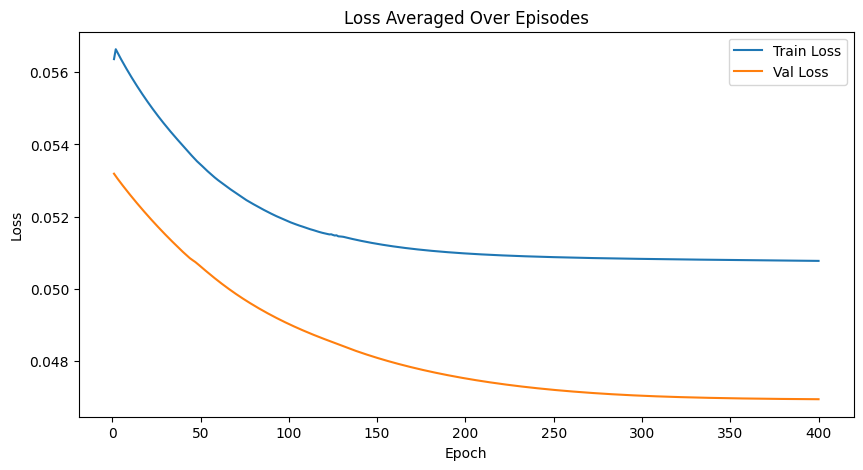

In [22]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_values, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_values, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Averaged Over Episodes')
plt.legend()
plt.show()

In [23]:
# saving the model
torch.save(model.state_dict(), "/content/drive/MyDrive/DecisionLSTM.pt")